In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm, style,gridspec
from matplotlib.ticker import LinearLocator
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize, fftpack, stats
from scipy.integrate import odeint

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

Z-score:  3.4661629670697414


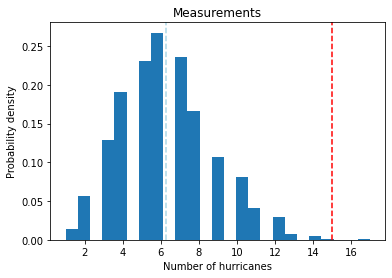

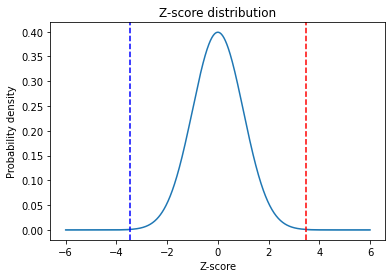

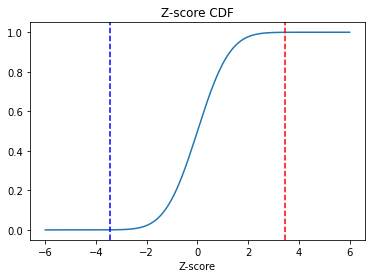

p-value for Z-score of 3.47 is 0.001
p-value for Z-score of 3 is 0.003


In [62]:
# We assume that the expected value of hurricanes is 6.3 per year
mu = 6.3

# In 2005, there were 15 hurricanes
x0 = 15

# The standard deviation is the square root of the expected value
sigma = np.sqrt(mu)

# Calculate the Z-score, which measures how many standard deviations away from the mean the observation is
z = abs(x0 - mu) / sigma

print("Z-score: ", z)

# Plot a histogram of measurements, assuming a Poisson distribution, and mark the observation and the mean
x = stats.poisson.rvs(mu=mu, loc=0, size=1000)
plt.hist(x, bins=25, density=True)
plt.axvline(x0, linestyle='--', color='red')
plt.axvline(mu, linestyle='--', color='lightblue')
plt.title("Measurements")
plt.ylabel("Probability density")
plt.xlabel("Number of hurricanes")
plt.show()

# Plot the normal probability density function (pdf) and shade the areas that correspond to the tails of the Z-score
xs = np.linspace(-6, 6, 1000)
ts = stats.norm.pdf(xs)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(z), color='lightblue')
plt.axvline(z, linestyle='--', color='red')
plt.axvline(-z, linestyle='--', color='blue')
plt.title("Z-score distribution")
plt.ylabel("Probability density")
plt.xlabel("Z-score")
plt.show()


# Plot the Gaussian Cumulative Distribution Function (CDF) and mark the Z-score
cs = stats.norm.cdf(xs)
plt.plot(xs, cs)
plt.axvline(z, linestyle='--', color='red')
plt.axvline(-z, linestyle='--', color='blue')
plt.title("Z-score CDF")
plt.xlabel("Z-score")
plt.show()


# Calculate the p-value as the sum of the area under the tails of the Z-score
pvalue_1 = stats.norm.cdf(-z) + (1. - stats.norm.cdf(z))
pvalue_2 = stats.norm.cdf(-3) + (1. - stats.norm.cdf(3))
print("p-value for Z-score of {:.2f} is {:.3f}".format(z, pvalue_1))
print("p-value for Z-score of 3 is {:.3f}".format(pvalue_2))


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

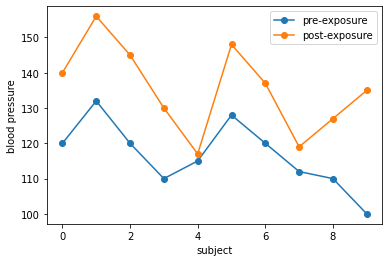

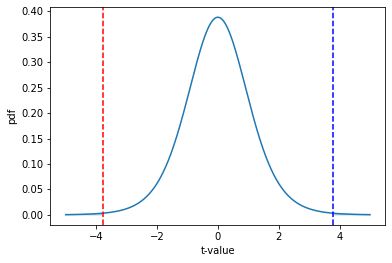

The p-value (0.0043) is less than the significance level (0.05),
so we reject the null hypothesis.
The change in blood pressure within the sample is statistically significant.


In [63]:
# define the data
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

# plot the raw data
plt.plot(pre, '-o', label="pre-exposure")
plt.plot(post, '-o', label="post-exposure")
plt.xlabel('subject')
plt.ylabel('blood pressure')
plt.legend()
plt.show()

# calculate the test statistics
n = len(pre)
mu_pre, mu_post = np.mean(pre), np.mean(post)
sigma_pre, sigma_post = np.std(pre, ddof=1), np.std(post, ddof=1)
sigma = np.sqrt(sigma_pre**2 + sigma_post**2) / np.sqrt(2)
t = (mu_pre - mu_post) / (sigma * np.sqrt(2/n))

# plot the test statistics and its pdf
xs = np.linspace(-5, 5, 1000)
ts = stats.t.pdf(xs, n - 1)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(t), color='lightblue')
plt.axvline(t, linestyle='--', color='red')
plt.axvline(-t, linestyle='--', color='blue')
plt.xlabel('t-value')
plt.ylabel('pdf')
plt.show()

# calculate the p-value and determine statistical significance
p_value = stats.t.sf(np.abs(t), n - 1) * 2
alpha = 0.05
if p_value <= alpha:
    print(f"The p-value ({p_value:.4f}) is less than the significance level ({alpha}),\nso we reject the null hypothesis.\nThe change in blood pressure within the sample is statistically significant.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than the significance level ({alpha}),\nso we fail to reject the null hypothesis.\nThe change in blood pressure within the sample is not statistically significant.")


3\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

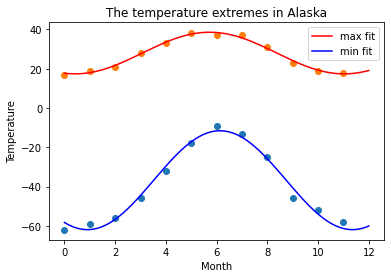

In [64]:
max_temperature = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_temperature = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months = np.arange(12)

# Plot these temperatures.
plt.plot(months, min_temperature, 'o', months, max_temperature,'o')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('The temperature extremes in Alaska')
plt.legend(['Minimum temperature','Maximum temperature' ])

def cos(t, a,b,c,d):
    return a * np.sin(b * t + c) + d

# Fit a cosine function to the data
params_max, cov_max = optimize.curve_fit(cos, months,max_temperature, [10, 1, 0, 20])
params_min, cov_min = optimize.curve_fit(cos, months,min_temperature, [30, 1, 0, -40])

# Plot the fits
days = np.linspace(0, 12, num=365)
plt.plot(days, cos(days, *params_max), '-r', label='max fit')
plt.plot(days, cos(days, *params_min), '-b', label='min fit')
plt.legend()

plt.show()


4\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't got it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature named `residual` contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable `distances`.

- Considering only the "residual" feature, create an histogram with the appropriate binning and plot it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [65]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2023-02-20 22:44:54--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2023-02-20 22:44:55--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc66acadcb0d6ec7c78ea3b94ae.dl.dropboxusercontent.com/cd/0/inline/B26pMgTR0oA8sNnGjW0gzeXpN8pHFnHyDr6PxHurqMS1pWqLH19FxmVRVdLOo-oZ9AJnXIo6X1ohiiG42v6Lpyg1Ru8aFACr8P9AgWSE-egaappdTTHrIytuUvln6Xt_spdGzI2mqxeUkv5oJwya_ZSxiNmAkgnGkeB0-GUS6cHGEg/file# [following]
--2023-02-20 22:44:55--  https://ucc66acadcb0d6ec7c78ea3b94ae.dl.dropboxusercontent.com/cd/0/inline/B26pMgTR0oA8sNnGjW0gzeXpN8pHFnHyDr6PxHurqMS1pWqLH19FxmVRVdLOo-o

R-squared = -0.023780574508061925 
R = nan
Covariance matrix:
 [[1.         0.22893393]
 [0.22893393 1.        ]]
Degrees of freedom = 48
Chi-squared = inf
p-value = 0.0
The fit is considered unsatisfactory because the p-value is < alpha.


/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-66-fa2ea9ba1d8c>:21: RuntimeWarning: invalid value encountered in sqrt
  print("R-squared =", rsq, "\nR =", np.sqrt(rsq))
<ipython-input-66-fa2ea9ba1d8c>:25: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(((residual)**2) / poisson_err)


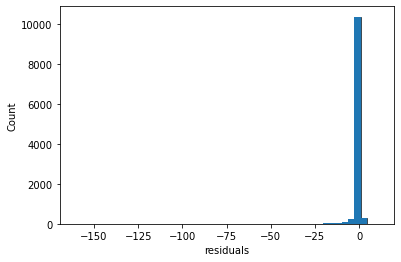

In [66]:
# Load the data and convert it to a Pandas dataframe
data = np.load("/content/data/residuals_261.pkl", allow_pickle=True).item()
data = pd.DataFrame(data, columns=['residuals', 'distances'])

# Create a histogram of the residuals
x = data['residuals']
sns.histplot(x, bins=np.linspace(x.min(), x.max()))

# Fit a Gaussian curve to the data to better understand it
y, bins, _ = plt.hist(x, bins=np.linspace(x.min(), x.max()))
gauss = lambda x, a, mu, sigma, b: a * stats.norm.pdf(x, mu, sigma) + b
bin_centers = 0.5 * (bins[1:] + bins[:-1])
poisson_err = np.sqrt(np.abs(y))
par, cov = optimize.curve_fit(gauss, xdata=bin_centers, ydata=y, sigma=poisson_err)

# Calculate the goodness of fit
residual = y - gauss(bin_centers, *par)
ssr = np.sum((residual)**2)
tss = np.sum((np.mean(y) - y)**2)
rsq = 1 - ssr / tss
print("R-squared =", rsq, "\nR =", np.sqrt(rsq))
print("Covariance matrix:\n", np.corrcoef(bin_centers, y))
ndof = len(y) - 1
print("Degrees of freedom =", ndof)
chi2 = np.sum(((residual)**2) / poisson_err)
print("Chi-squared =", chi2)
p_value = 1 - stats.chi2.cdf(chi2, ndof)
print("p-value =", p_value)

# Determine the significance of the fit
alpha = 0.05
if p_value <= alpha:
    print("The fit is considered unsatisfactory because the p-value is < alpha.")
else:
    print("The fit is considered satisfactory because the p-value is > alpha.")


5\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [67]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
data = pd.read_csv('/content/munich_temperatures_average_with_bad_data.txt', sep =' ', names = ['time', 'temperatures'])

--2023-02-20 22:44:58--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2023-02-20 22:44:58--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfac48a9b8cf169b4efbaad8d6b.dl.dropboxusercontent.com/cd/0/inline/B25dgKCNE9TXX5JU7PymdMkC47BWys7RTBn1ShqPRztMDpJDGOTs5B0rDHoL4_GfQhdlli0jaWp0DjV3-jGYmE-A0qwYv-i_uGS6dQARbJeSDH2g3U-br0lbv47nVFzUiayH5-Nw9hbGBDWvXG2idiopvOF9wOOPnRkYJGjIR8DtRQ/file# [following]
--2023-02-20 22:44:58--  https://ucfac48a9b8cf169b4efbaad8d6b.dl.dropboxusercon

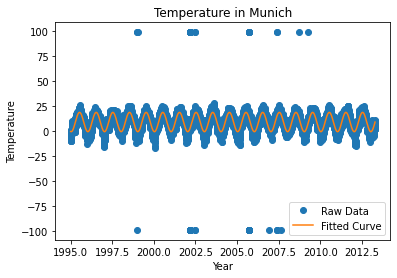

Best-fit values of the parameters are: 
 a = -9.671613795908375 
 b = 0.9997396545591247 
 c = 15.621313429070495 
 d = 9.05135223033952

The overall average temperature in Munich is: 8.9 °C
The typical daily average values predicted by the model for the coldest time of year are: -0.62 °C
The typical daily average values predicted by the model for the hottest time of year are: 18.72 °C


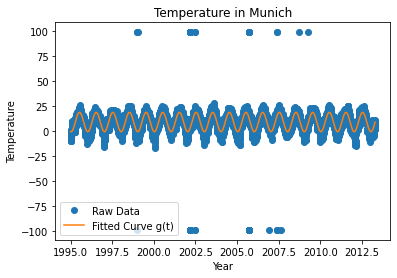

F-test statistic: 0.227
p-value: 0.634
Additional parameter necessary:  NO


(0.22673792447401633, 0.6339688134849117)

In [68]:
# Define the function to fit
f = lambda t, a, b, c: a * np.cos(2 * np.pi * t + b) + c

# Generate the data
t, y = data['time'], data['temperatures']

# Fit the function to the data
fparams, fcov = optimize.curve_fit(f, t, y)

# Plot the fitted function
plt.plot(t, y, 'o')
plt.plot(t, f(t, *fparams))
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature in Munich')
plt.legend(['Raw Data', 'Fitted Curve'])
plt.show()

# Define another function with an additional parameter to fit
g = lambda t, a, b, c, d: a * np.cos(2 * b * np.pi * t + c) + d

# Fit the new function to the data
gparams, pcov = optimize.curve_fit(g, t, y)

# Print some useful information about the fit
print('Best-fit values of the parameters are: \n a = {} \n b = {} \n c = {} \n d = {}'
      .format(*gparams))
print('\nThe overall average temperature in Munich is: {:1.1f} °C'.format(np.mean(y)))
print('The typical daily average values predicted by the model for the coldest time of year are: {:.2f} °C'
      .format(g(t, *gparams).min()))
print('The typical daily average values predicted by the model for the hottest time of year are: {:.2f} °C'
      .format(g(t, *gparams).max()))

# Plot the new fitted function
plt.plot(t, y, 'o')
plt.plot(t, g(t, *gparams))
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature in Munich')
plt.legend(['Raw Data', 'Fitted Curve g(t)'])
plt.show()

# Define a function to calculate the sum of squared residuals
def SSR(y_th):
    residual = y - y_th
    return np.sum(residual**2)

# Calculate the sum of squared residuals for each fit
SSR_f = SSR(f(t, *fparams))
SSR_g = SSR(g(t, *gparams))

# Define a function to perform the Fisher F-test
def fisher_f_test(sample1, sample2, nbins):
    """
    Calculates the Fisher F-test for two samples.
    """
    # Calculate the F-test statistic
    ndof1, ndof2 = 3, 4
    F = ((SSR_f - SSR_g) / (ndof2 - ndof1)) / (SSR_g / (nbins - ndof2))
    p_value = 1 - stats.f.cdf(F, ndof2 - ndof1, nbins - ndof2)
    
    print("F-test statistic: {:.3f}".format(F))
    print("p-value: {:.3f}".format(p_value))
    print("Additional parameter necessary: ", "YES" if p_value < 0.10 else "NO")

    return F, p_value

# Perform the Fisher F-test
fisher_f_test(f(t, *fparams), g(t, *gparams), nbins=len(t))
